In [1]:
# !pip install 'qiskit[visualization]'
# !pip install qiskit_aer
# !pip install qiskit_ibm_runtime

In [2]:
import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_distribution
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.classical import expr
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_bloch_vector
from qiskit.visualization.bloch import Bloch
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
import qiskit_aer
import math
import numpy as np
import matplotlib.pyplot as plt
import random

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, 
                              pauli_error, depolarizing_error, thermal_relaxation_error)

### E91 protocol

The E91 protocol, proposed by Artur Ekert in 1991, is a quantum key distribution scheme
that uses entangled quantum states and relies on Bell's inequality to detect eavesdropping.
Unlike BB84, which uses prepared quantum states, E91 uses quantum entanglement as its
security foundation.

1. Entangled Pair Generation:
   - A source creates pairs of entangled qubits $|\Psi^+\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$
   - Each particle of the pair is sent to Alice and Bob respectively

2. Measurement Basis Selection:
   - Alice randomly chooses between three measurement axis: {z, z+x, x}
   - Bob randomly chooses between three measurement axis: {z+x, z, z-x}
   - Measurements are performed independently

3. Public Discussion:
   - Alice and Bob publicly announce their chosen measurement bases
   - They keep results for key generation when their bases are the same
   - They use the results to calculate statistic value S in Bell's inequality.  The closer the value S to $2\sqrt{2}$, the lesser likely of eavesdropping. If value S is less than 2, it is very likely of eavesdropping and the protocol is aborted.

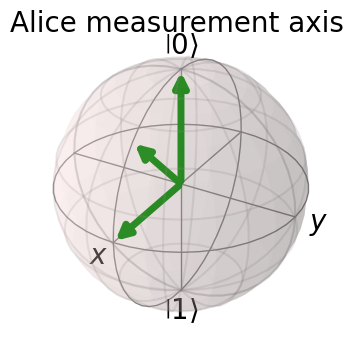

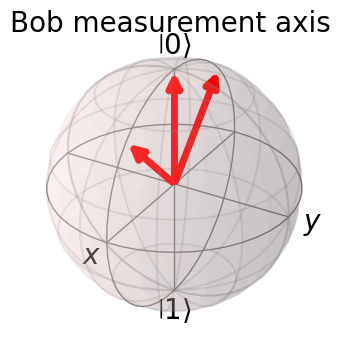

In [3]:
# alice's measurement axis
alice_axis = Bloch(figsize=(3, 3))
alice_axis.vector_color = ['green']
alice_axis.add_vectors([[0, 0, 1], [1/math.sqrt(2), 0, 1/math.sqrt(2)], [1, 0, 0]])
alice_axis.render(title='Alice measurement axis')

# bob's measurement axis
bob_axis = Bloch(figsize=(3, 3))
bob_axis.vector_color = ['red']
bob_axis.add_vectors([[-1/math.sqrt(2), 0, 1/math.sqrt(2)], [0, 0, 1], [1/math.sqrt(2), 0, 1/math.sqrt(2)]])
bob_axis.render(title='Bob measurement axis')

Illustrate an entangled qubits measured by Alice and Bob with randomly choosing axis respectively.

Define ```do_e91()``` which prepare qubits to generate random axis and entangled qubit for measurement.

Note:
- This circuit uses 2 qubits to randomly generate 4 conditions. It cannot have equal probability to choose from 3 possible measurement axis for both Alice and Bob. Therefore, it may bias on some measurement axis.

In [4]:
def do_e91(qc, areg, breg, enareg, enbreg, c_a, c_b, c_ena, c_enb, c_eve, eve_rate):
    """
    Implements the E91 (Ekert91) quantum key distribution protocol using quantum circuits.
    
    The protocol creates entangled pairs and performs measurements along different bases
    to establish a shared secret key between Alice and Bob. It uses Bell states and
    measurements along three different angles: z-basis (0°), z+x basis (45°), and 
    x-basis/z-x basis (90°/-90°) for Alice and Bob respectively.

    Parameters:
        qc (QuantumCircuit): Quantum circuit for implementing the protocol
        areg (QuantumRegister): 2-qubit register for Alice's basis selection
        breg (QuantumRegister): 2-qubit register for Bob's basis selection
        enareg (QuantumRegister): Single-qubit register for Alice's entangled qubit
        enbreg (QuantumRegister): Single-qubit register for Bob's entangled qubit
        c_a (ClassicalRegister): 2-bit register to store Alice's basis choice
        c_b (ClassicalRegister): 2-bit register to store Bob's basis choice
        c_ena (ClassicalRegister): Register for Alice's measurement result
        c_enb (ClassicalRegister): Register for Bob's measurement result
        c_eve (ClassicalRegister): Optional register for Eve's measurement (for simulation)
        eve_rate (float): Probability of Eve's intervention (0 to 1)

    Protocol Steps:
    1. Initialize all qubits to |0⟩ state
    2. Create superposition for basis selection using Hadamard gates
    3. Generate entangled Bell state between Alice and Bob's qubits
    4. Measure basis choices for Alice and Bob
    5. Perform measurements along three different angles:
       - Alice: z basis, z+x basis, x basis
       - Bob: z basis, z+x basis, z-x basis
    6. Optional: Simulate eavesdropper (Eve) measurements

    Measurement Bases:
    - |00> (python string '00'): z basis
    - |01> (python string '10'): z+x basis
    - |10>, |11> (python string '01', '11'): x basis for Alice, z-x basis for Bob

    Note: The function uses conditional operations (if_test) to perform different 
    measurements based on the randomly selected bases.
    """
    qc.initialize([1, 0, 0, 0], areg)
    qc.initialize([1, 0, 0, 0], breg)
    qc.initialize([1, 0], enareg)
    qc.initialize([1, 0], enbreg)
    qc.h(areg)
    qc.h(breg)
    qc.h(enareg)
    qc.cx(enareg, enbreg)
    qc.barrier(label='init')
    
    # randomly generate 2 bits for Alice
    qc.measure(areg, c_a)
    with qc.if_test((c_a[1], 0)) as else_:
        with qc.if_test((c_a[0], 0)) as else1_:
            # measure along z
            qc.measure(enareg, c_ena)
        with else1_:
            # measure along z+x
            qc.ry(-math.pi/4, enareg)
            qc.measure(enareg, c_ena)
            qc.ry(math.pi/4, enareg)
    with else_:
        # measure along x
        qc.ry(-math.pi/2, enareg)
        qc.measure(enareg, c_ena)
        qc.ry(math.pi/2, enareg)
    qc.barrier(label='alice')

    if c_eve is not None:
        if random.random() < eve_rate:
            qc.measure(enbreg, c_eve)
            qc.barrier(label='eve')

    # randomly generate 2 bits for Bob
    qc.measure(breg, c_b)
    with qc.if_test((c_b[1], 0)) as else_:
        with qc.if_test((c_b[0], 0)) as else1_:
            # measure along z
            qc.measure(enbreg, c_enb)
        with else1_:
            # measure along z+x
            qc.ry(-math.pi/4, enbreg)
            qc.measure(enbreg, c_enb)
            qc.ry(math.pi/4, enbreg)
    with else_:
        # measure along z-x
        qc.ry(math.pi/4, enbreg)
        qc.measure(enbreg, c_enb)
        qc.ry(-math.pi/4, enbreg)
    qc.barrier(label='bob')

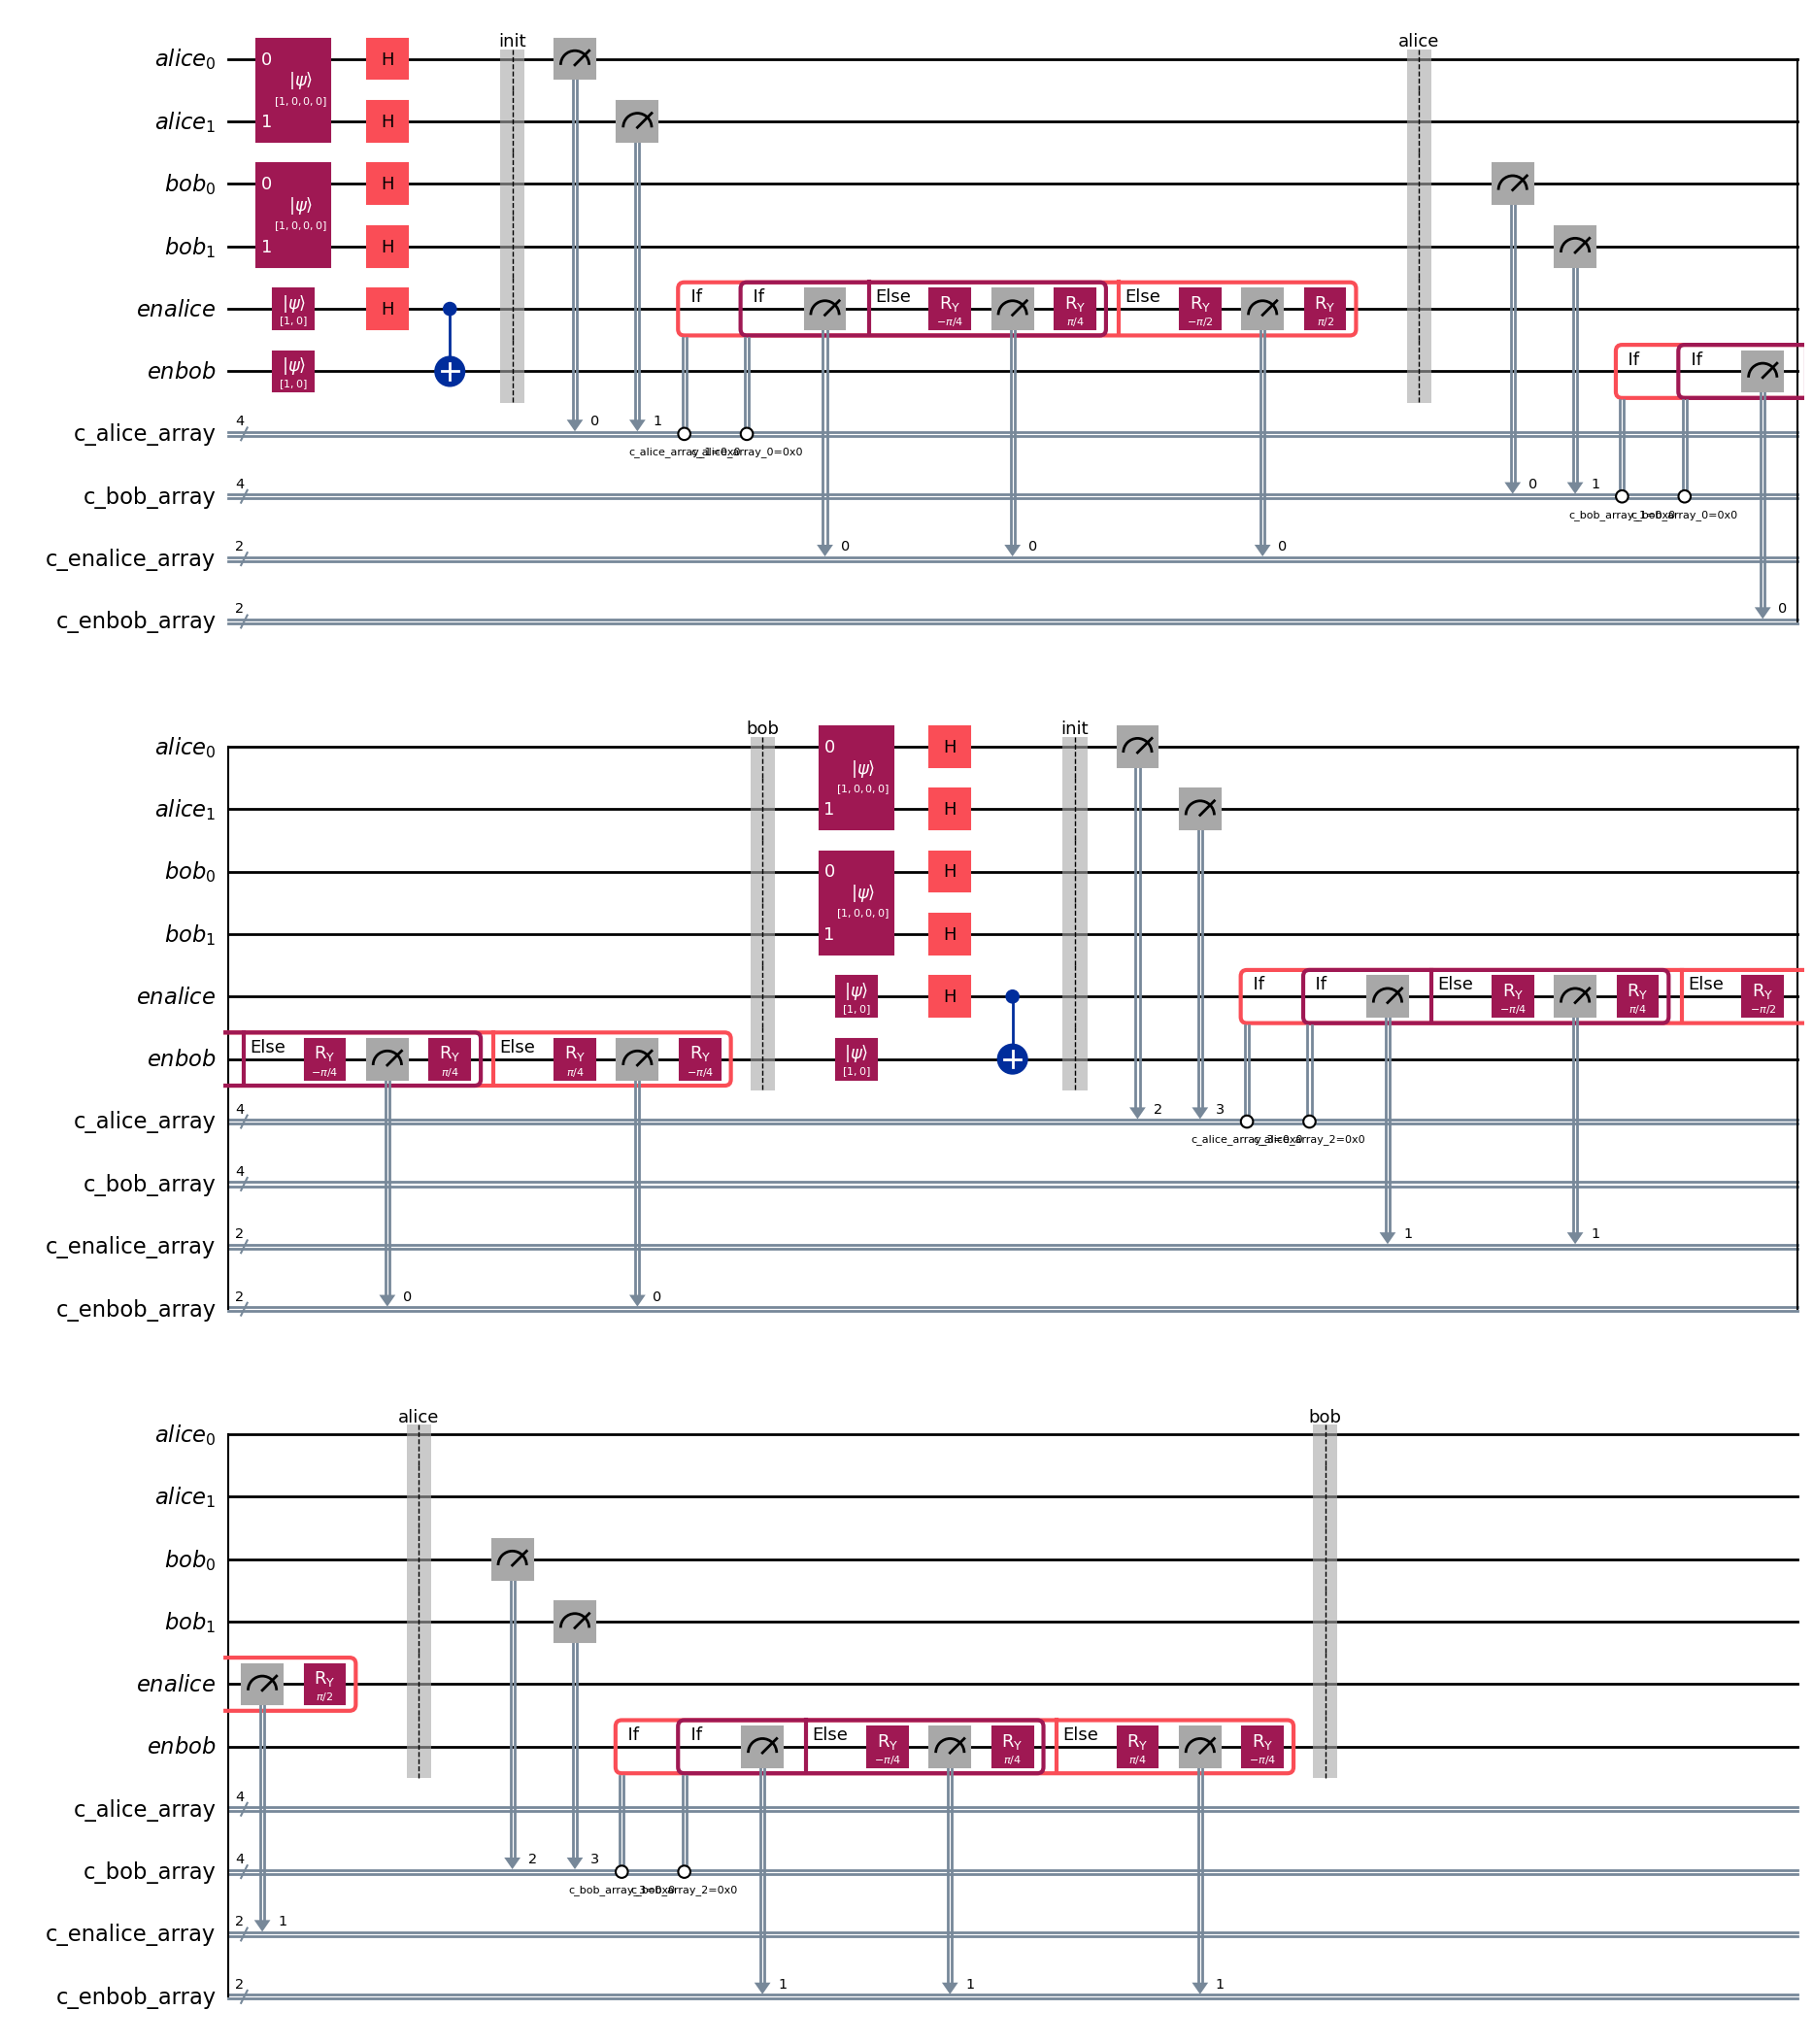

In [5]:
N = 2
areg = QuantumRegister(2, "alice")          # for generating 2 random classical bits for alice
breg = QuantumRegister(2, "bob")            # for generating 2 random classical bits for bob
enareg = QuantumRegister(1, "enalice")      # alice part of entangled qubit
enbreg = QuantumRegister(1, "enbob")        # bob part of entangled qubit
c_a_arrayreg = ClassicalRegister(2*N, "c_alice_array")  # record alice randomly generated axis code, 2 bits each
c_b_arrayreg = ClassicalRegister(2*N, "c_bob_array")    # record bob randomly generated axis code, 2 bits each
c_ena_arrayreg = ClassicalRegister(N, "c_enalice_array")    # record alice measured value
c_enb_arrayreg = ClassicalRegister(N, "c_enbob_array")      # record bob measured value

qc = QuantumCircuit(areg, breg, enareg, enbreg, c_a_arrayreg, c_b_arrayreg, 
                    c_ena_arrayreg, c_enb_arrayreg)

for i in range(N):
    do_e91(qc, areg, breg, enareg, enbreg, c_a_arrayreg[2*i:2*i+2], c_b_arrayreg[2*i:2*i+2], 
           c_ena_arrayreg[i], c_enb_arrayreg[i], None, 0)

display(qc.draw('mpl'))

Prepare circuit to use N entangled qubits to make a shared key for Alice and Bob.

In [6]:
N = 2000
areg = QuantumRegister(2, "alice")          # for generating 2 random classical bits for alice
breg = QuantumRegister(2, "bob")            # for generating 2 random classical bits for bob
enareg = QuantumRegister(1, "enalice")      # alice part of entangled qubit
enbreg = QuantumRegister(1, "enbob")        # bob part of entangled qubit
c_a_arrayreg = ClassicalRegister(2*N, "c_alice_array")  # record alice randomly generated axis code, 2 bits each
c_b_arrayreg = ClassicalRegister(2*N, "c_bob_array")    # record bob randomly generated axis code, 2 bits each
c_ena_arrayreg = ClassicalRegister(N, "c_enalice_array")    # record alice measured value
c_enb_arrayreg = ClassicalRegister(N, "c_enbob_array")      # record bob measured value
c_evereg = ClassicalRegister(1, "c_eve")    # for eve eavesdrop measure

qc = QuantumCircuit(areg, breg, enareg, enbreg, c_a_arrayreg, c_b_arrayreg, 
                    c_ena_arrayreg, c_enb_arrayreg, c_evereg)

for i in range(N):
    do_e91(qc, areg, breg, enareg, enbreg, c_a_arrayreg[2*i:2*i+2], c_b_arrayreg[2*i:2*i+2], 
           c_ena_arrayreg[i], c_enb_arrayreg[i], c_evereg, 0)

# display(qc.draw('mpl'))

Execute the circuit.

In [7]:
sampler = Sampler(mode=AerSimulator())
job = sampler.run([qc], shots=1)
result = job.result()[0]
samp_alice = result.data.c_alice_array.get_counts()
samp_bob = result.data.c_bob_array.get_counts()
samp_enalice = result.data.c_enalice_array.get_counts()
samp_enbob = result.data.c_enbob_array.get_counts()
# print(samp_alice, samp_bob)
# print(samp_enalice, samp_enbob)

Convert qiskit bit convention (rightmost string char is bit 0) to python string convention (leftmost char is array index 0).

In [8]:
# reverse string to turn qiskit bit 0 (rightmost bit) to *_array[0]
alice_array = list(samp_alice.keys())[0][::-1]
bob_array = list(samp_bob.keys())[0][::-1]
enalice_array = list(samp_enalice.keys())[0][::-1]
enbob_array = list(samp_enbob.keys())[0][::-1]
# print(alice_array, bob_array)
# print(enalice_array, enbob_array)

Define ```calc_keys_and_s()``` to calculate the keys and S statistic from Alice and Bob's measured basis and measured values.

In [9]:
def calc_keys_and_s(alice_array, bob_array, enalice_array, enbob_array):
    """
    Calculates alice key, bob key and S statistic for the E91 protocol.
    
    This function analyzes the measurement results from an E91 quantum key distribution
    protocol implementation to:
    1. Calculate the keys from Alice and Bob's measurements
    2. Compute the S parameter for Bell's inequality test
    
    Parameters:
        alice_array (str): String containing Alice's basis choices
                          Format: Sequence of 2-bit strings
                          - '00': z basis
                          - '10': z+x basis
                          - '01', '11': x basis
        
        bob_array (str): String containing Bob's basis choices
                        Format: Sequence of 2-bit strings
                        - '00': z basis
                        - '10'': z+x basis
                        - '01', '11': z-x basis
        
        enalice_array (str): String containing Alice's measurement results
                            Format: Sequence of single bits ('0' or '1')
                            - '0': Spin up/+1 measurement
                            - '1': Spin down/-1 measurement
        
        enbob_array (str): String containing Bob's measurement results
                          Format: Sequence of single bits ('0' or '1')
                          - '0': Spin up/+1 measurement
                          - '1': Spin down/-1 measurement
    Returns:
        tuple: (alice_key, bob_key, s_param)
            - alice_key (str): Alice's key string
            - bob_key (str): Bob's key string
            - s_stat (float): Calculated S statistic for Bell's inequality test
    """
    alice_key = []
    bob_key = []
    correlate_count = [0, 0, 0, 0]
    correlate_value = [0, 0, 0, 0]
    for i in range(len(enalice_array)):
        # check if both alice and bob are "00" or "10"
        if (alice_array[2*i:2*i+2] == "00" and bob_array[2*i:2*i+2] == "00") or (alice_array[2*i:2*i+2] == "10" and bob_array[2*i:2*i+2] == "10"):
            alice_key.append(enalice_array[i])
            bob_key.append(enbob_array[i])
        if enalice_array[i] == '0':
            a_value = 1
        else:
            a_value = -1
        if enbob_array[i] == '0':
            b_value = 1
        else:
            b_value = -1
        if alice_array[2*i:2*i+2] == "00" and bob_array[2*i:2*i+2] == "10": 
            # alice z, bob z+x
            correlate_value[0] += a_value*b_value
            correlate_count[0] += 1
        if alice_array[2*i:2*i+2] == "00" and (bob_array[2*i:2*i+2] == "01" or bob_array[2*i:2*i+2] == "11"):
            # alice z, bob z-x
            correlate_value[1] += a_value*b_value
            correlate_count[1] += 1
        if (alice_array[2*i:2*i+2] == "01" or alice_array[2*i:2*i+2] == "11") and bob_array[2*i:2*i+2] == "10":
            # alice x, bob z+x
            correlate_value[2] += a_value*b_value
            correlate_count[2] += 1
        if (alice_array[2*i:2*i+2] == "01" or alice_array[2*i:2*i+2] == "11") and (bob_array[2*i:2*i+2] == "01" or bob_array[2*i:2*i+2] == "11"):
            # alice x, bob z-x
            correlate_value[3] -= a_value*b_value
            correlate_count[3] += 1

    s_stat = 0
    for i, c in enumerate(correlate_count):
        if c != 0:
            s_stat += correlate_value[i]/c
    return ''.join(alice_key), ''.join(bob_key), s_stat

In [10]:
def calc_mismatch_rate(s1, s2):
    mismatch_count = 0
    for i in range(len(s1)):
        if s1[i] != s2[i]:
            mismatch_count += 1
    return mismatch_count / len(s1)

In [11]:
alice_key, bob_key, s_stat = calc_keys_and_s(alice_array, bob_array, enalice_array, enbob_array)
mismatch_rate = calc_mismatch_rate(alice_key, bob_key)
print("S: ", s_stat, " for reference: 2\sqrt{2} =", 2*math.sqrt(2))
print("key length: ", len(alice_key))
print("Alice's key: ", alice_key)
print("Bob's key  : ", bob_key)
if mismatch_rate == 0:
    print("key match: True")
else:
    print("key mismatch rate: ", mismatch_rate)

S:  2.881700691022725  for reference: 2\sqrt{2} = 2.8284271247461903
key length:  229
Alice's key:  1011000000000110001110101100101011011110001000101111010110010001001010011110000100010111010010011110000110000011101001010011000110001000001011001110010011010100101101110111010110110011100110100111101011100111101110111110010101001
Bob's key  :  1011000000000110001110101100101011011110001000101111010110010001001010011110000100010111010010011110000110000011101001010011000110001000001011001110010011010100101101110111010110110011100110100111101011100111101110111110010101001
key match: True


### Eavesdropping

Illustrate eavesdropping by Eve.

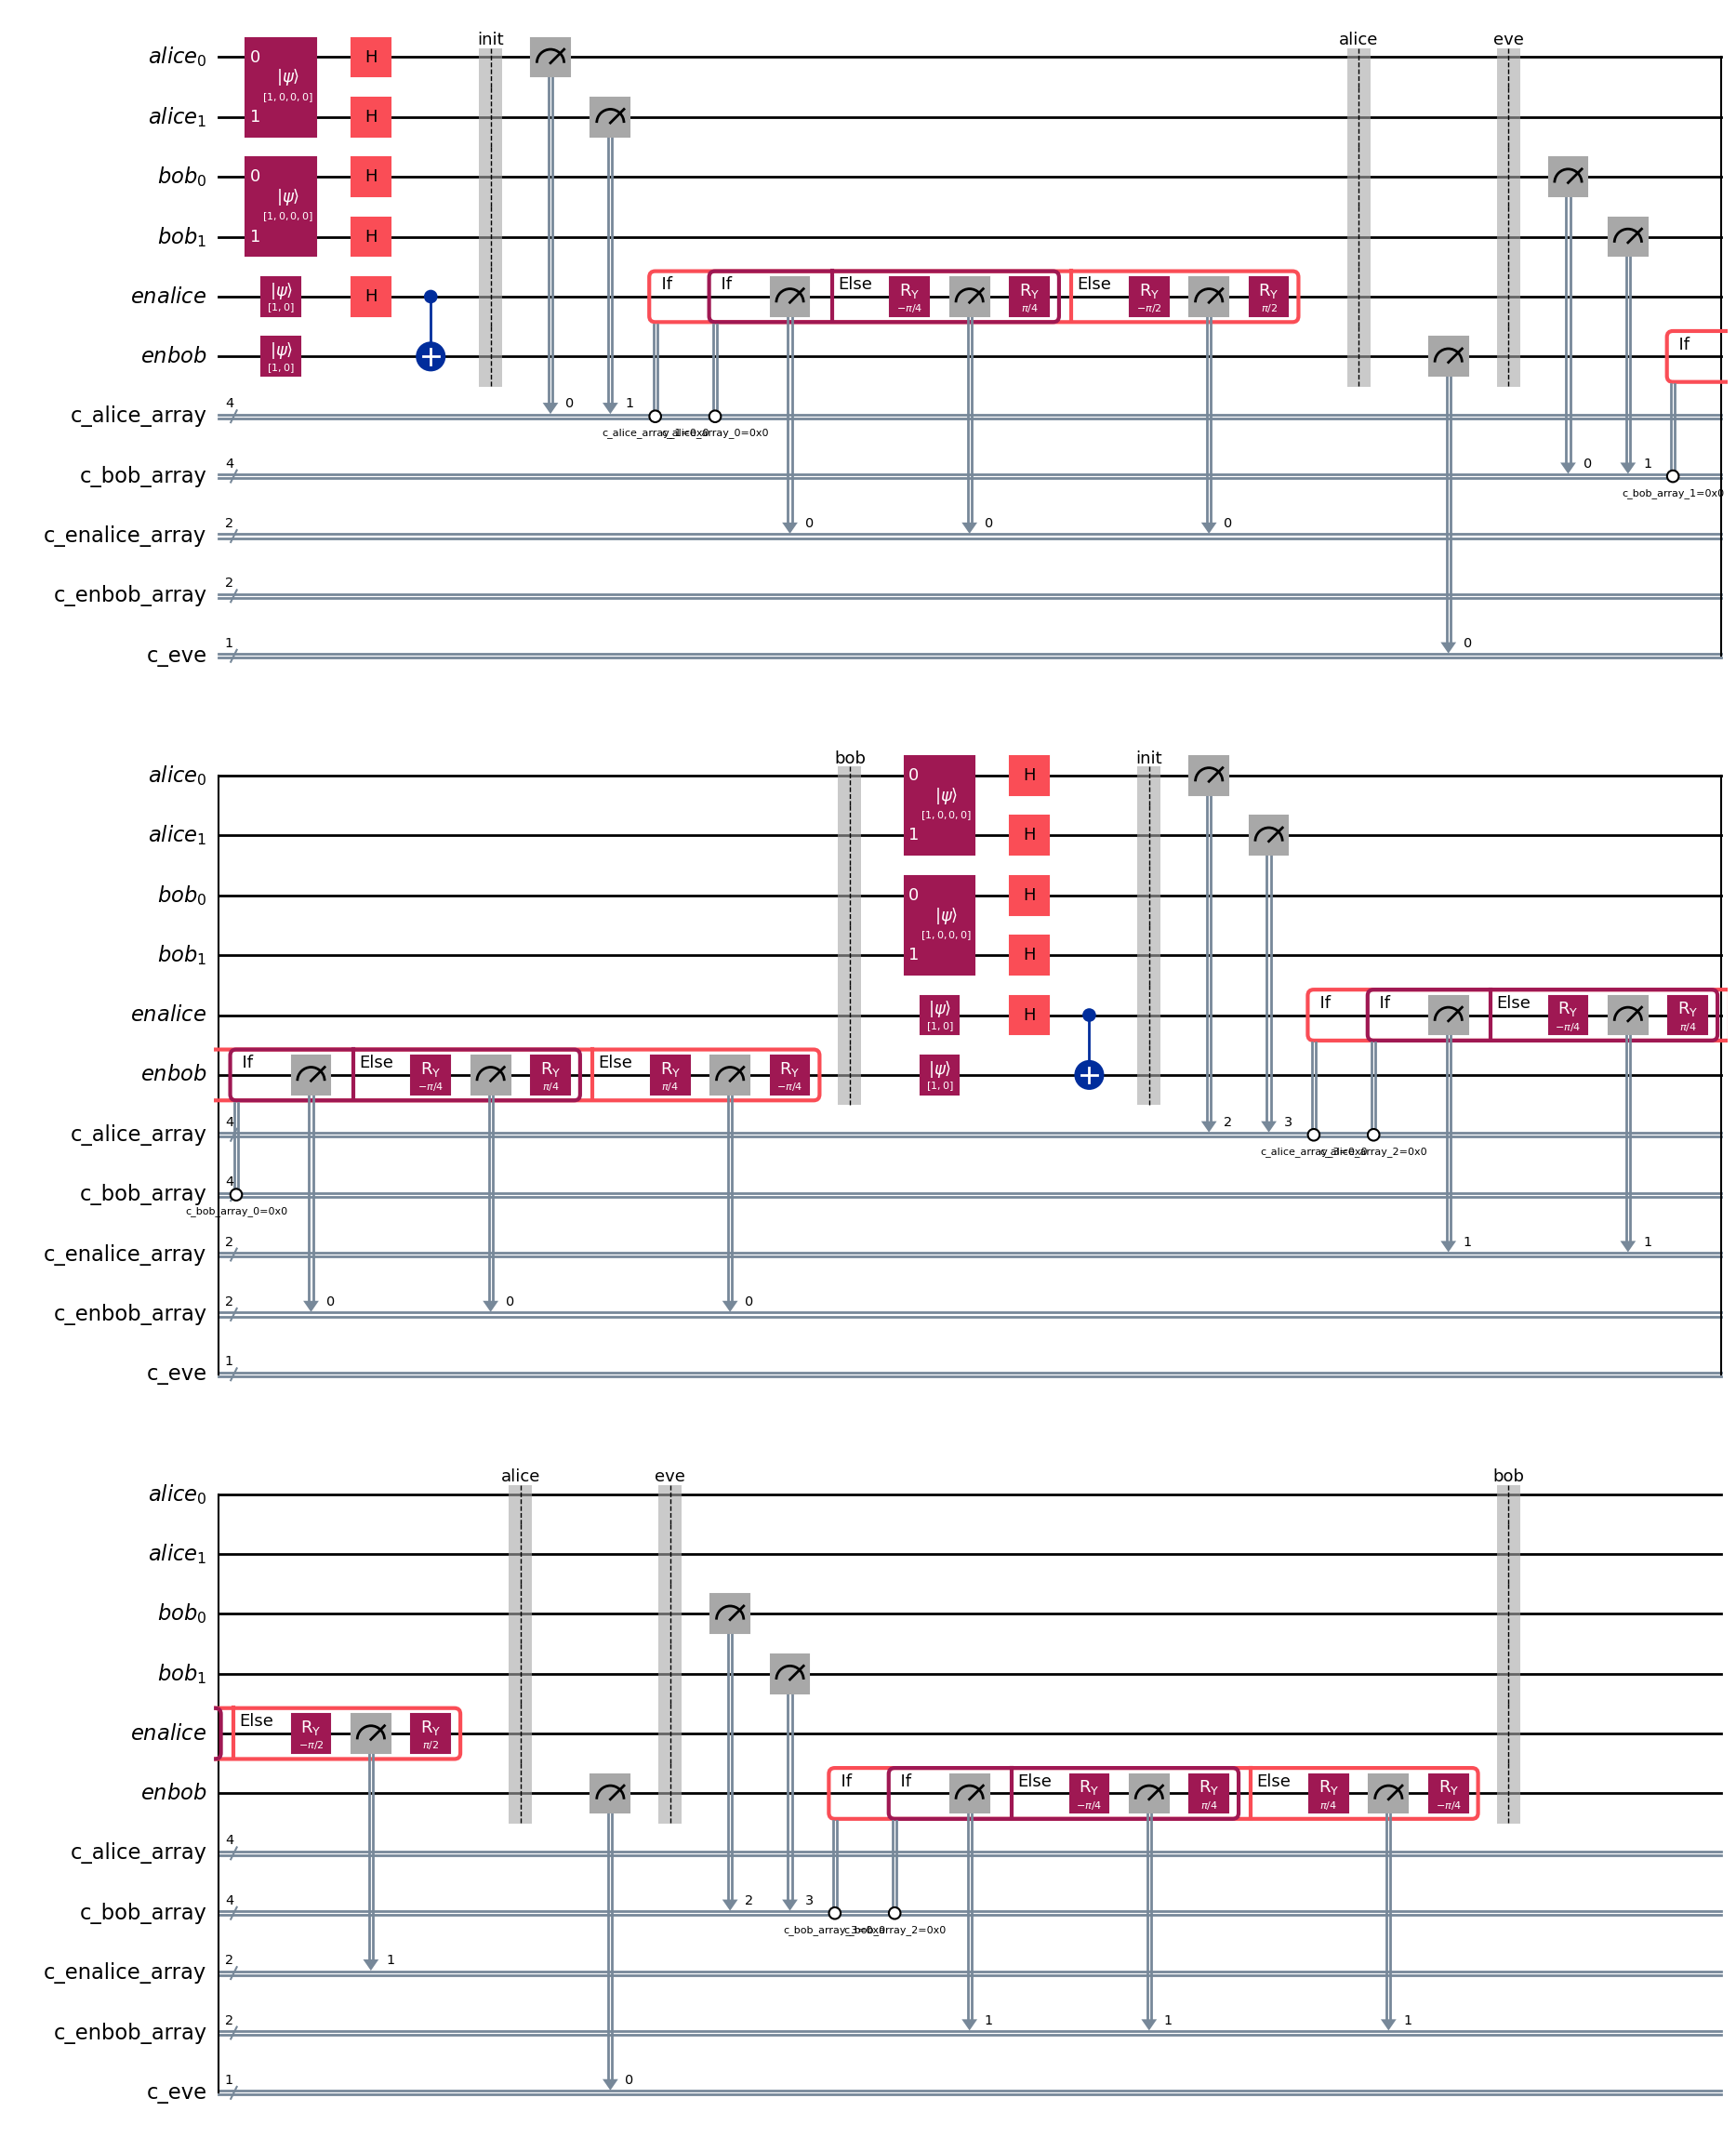

In [12]:
N = 2
areg = QuantumRegister(2, "alice")          # for generating 2 random classical bits for alice
breg = QuantumRegister(2, "bob")            # for generating 2 random classical bits for bob
enareg = QuantumRegister(1, "enalice")      # alice part of entangled qubit
enbreg = QuantumRegister(1, "enbob")        # bob part of entangled qubit
c_a_arrayreg = ClassicalRegister(2*N, "c_alice_array")  # record alice randomly generated axis code, 2 bits each
c_b_arrayreg = ClassicalRegister(2*N, "c_bob_array")    # record bob randomly generated axis code, 2 bits each
c_ena_arrayreg = ClassicalRegister(N, "c_enalice_array")    # record alice measured value
c_enb_arrayreg = ClassicalRegister(N, "c_enbob_array")      # record bob measured value
c_evereg = ClassicalRegister(1, "c_eve")    # for eve eavesdrop measure

qc = QuantumCircuit(areg, breg, enareg, enbreg, c_a_arrayreg, c_b_arrayreg, 
                    c_ena_arrayreg, c_enb_arrayreg, c_evereg)

for i in range(N):
    do_e91(qc, areg, breg, enareg, enbreg, c_a_arrayreg[2*i:2*i+2], c_b_arrayreg[2*i:2*i+2], 
           c_ena_arrayreg[i], c_enb_arrayreg[i], c_evereg, 1)   # eve_rate=1

display(qc.draw('mpl'))

Simulate eavesdropping.  Plot the relation of key mismatch rate and Bell's S statistic vs eavesdropping rate.

In [13]:
N = 2000
areg = QuantumRegister(2, "alice")          # for generating 2 random classical bits for alice
breg = QuantumRegister(2, "bob")            # for generating 2 random classical bits for bob
enareg = QuantumRegister(1, "enalice")      # alice part of entangled qubit
enbreg = QuantumRegister(1, "enbob")        # bob part of entangled qubit
c_a_arrayreg = ClassicalRegister(2*N, "c_alice_array")  # record alice randomly generated axis code, 2 bits each
c_b_arrayreg = ClassicalRegister(2*N, "c_bob_array")    # record bob randomly generated axis code, 2 bits each
c_ena_arrayreg = ClassicalRegister(N, "c_enalice_array")    # record alice measured value
c_enb_arrayreg = ClassicalRegister(N, "c_enbob_array")      # record bob measured value
c_evereg = ClassicalRegister(1, "c_eve")    # for eve eavesdrop measure

eavesdrop_rates = np.arange(0, 1.05, 0.05)
key_mismatch_rates = []
s_stats = []
for r in eavesdrop_rates:
    # print(r)
    qc = QuantumCircuit(areg, breg, enareg, enbreg, c_a_arrayreg, c_b_arrayreg, 
                        c_ena_arrayreg, c_enb_arrayreg, c_evereg)
    for i in range(N):
        do_e91(qc, areg, breg, enareg, enbreg, c_a_arrayreg[2*i:2*i+2], c_b_arrayreg[2*i:2*i+2], 
               c_ena_arrayreg[i], c_enb_arrayreg[i], c_evereg, r)
    sampler = Sampler(mode=AerSimulator())
    job = sampler.run([qc], shots=1)
    result = job.result()[0]
    samp_alice = result.data.c_alice_array.get_counts()
    samp_bob = result.data.c_bob_array.get_counts()
    samp_enalice = result.data.c_enalice_array.get_counts()
    samp_enbob = result.data.c_enbob_array.get_counts()

    # reverse string to turn qiskit bit 0 (rightmost bit) to *_array[0]
    alice_array = list(samp_alice.keys())[0][::-1]
    bob_array = list(samp_bob.keys())[0][::-1]
    enalice_array = list(samp_enalice.keys())[0][::-1]
    enbob_array = list(samp_enbob.keys())[0][::-1]

    alice_key, bob_key, s = calc_keys_and_s(alice_array, bob_array, enalice_array, enbob_array)
    key_mismatch_rates.append(calc_mismatch_rate(alice_key, bob_key))
    s_stats.append(s)

print(eavesdrop_rates)
print(key_mismatch_rates)
print(s_stats)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
[0.0, 0.008064516129032258, 0.004081632653061225, 0.03088803088803089, 0.022222222222222223, 0.025089605734767026, 0.03802281368821293, 0.04924242424242424, 0.04132231404958678, 0.04918032786885246, 0.07924528301886792, 0.06854838709677419, 0.08658008658008658, 0.07627118644067797, 0.07662835249042145, 0.08835341365461848, 0.125, 0.09219858156028368, 0.09375, 0.1124031007751938, 0.12454212454212454]
[2.8746443459273476, 2.8347987516758013, 2.7466479301807336, 2.5672493822382676, 2.3958141422801638, 2.548960627257336, 2.453284400104734, 2.4515714055336697, 2.246679717044975, 2.16977213591512, 2.247068650096892, 2.1510916588370046, 2.09330538921008, 1.9744375774114542, 1.8839091284972256, 1.7420251034333187, 1.7600898167512513, 1.6661484736491514, 1.4557630450491947, 1.512859141856979, 1.3646739666534806]


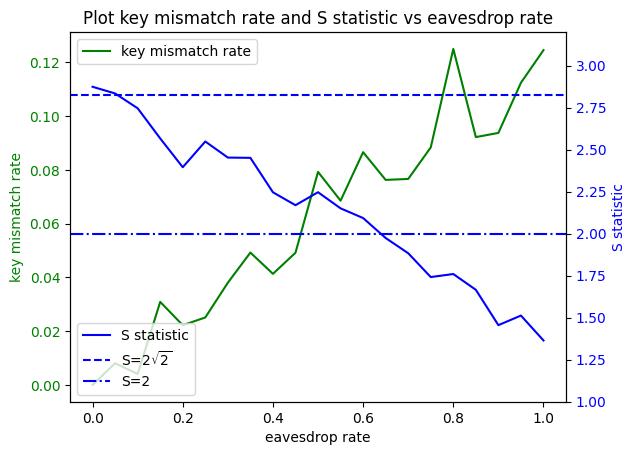

In [14]:
fig, ax1 = plt.subplots()

# Plot key mismatch rate against eavesdrop rate on the right axis
ax1.plot(eavesdrop_rates, key_mismatch_rates, label='key mismatch rate', color='green')
ax1.set_xlabel('eavesdrop rate')  # x-axis label
ax1.set_ylabel('key mismatch rate', color='green')  # y1-axis label on the left
ax1.tick_params(axis='y', labelcolor='green')  # Set color for the left y-axis ticks
ax1.legend()

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot S against eavesdrop rate on the left axis
ax2.plot(eavesdrop_rates, s_stats, label='S statistic', color='blue')
ax2.set_ylabel('S statistic', color='blue')  # y2-axis label on the right
ax2.tick_params(axis='y', labelcolor='blue')  # Set color for the right y-axis ticks
ax2.axhline(y=2*math.sqrt(2), color='blue', linestyle='--', label='S=$2\sqrt{2}$')
ax2.axhline(y=2, color='blue', linestyle='-.', label='S=2')
ax2.set_ylim(1, 3.2)
ax2.legend()

# Add a title
plt.title('Plot key mismatch rate and S statistic vs eavesdrop rate')

# Display the plot
plt.show()

### Noisy quantum simulator and key reconciliation

Noisy quantum simulator.

In [15]:
# Example error probabilities
p_reset = 0.005
p_meas = 0.005
p_gatex = 0.005
p_gatez = 0.005

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gatex = pauli_error([('X',p_gatex), ('I', 1 - p_gatex)])
error_gatez = pauli_error([('Z', p_gatez), ('I', 1 - p_gatez)])
error_gate1 = error_gatex.compose(error_gatez)
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_xz = NoiseModel()
noise_xz.add_all_qubit_quantum_error(error_reset, "reset")
noise_xz.add_all_qubit_quantum_error(error_meas, "measure")
noise_xz.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_xz.add_all_qubit_quantum_error(error_gate2, ["cx"])

# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_xz)

In [16]:
N = 2000
areg = QuantumRegister(2, "alice")          # for generating 2 random classical bits for alice
breg = QuantumRegister(2, "bob")            # for generating 2 random classical bits for bob
enareg = QuantumRegister(1, "enalice")      # alice part of entangled qubit
enbreg = QuantumRegister(1, "enbob")        # bob part of entangled qubit
c_a_arrayreg = ClassicalRegister(2*N, "c_alice_array")  # record alice randomly generated axis code, 2 bits each
c_b_arrayreg = ClassicalRegister(2*N, "c_bob_array")    # record bob randomly generated axis code, 2 bits each
c_ena_arrayreg = ClassicalRegister(N, "c_enalice_array")    # record alice measured value
c_enb_arrayreg = ClassicalRegister(N, "c_enbob_array")      # record bob measured value
c_evereg = ClassicalRegister(1, "c_eve")    # for eve eavesdrop measure

qc = QuantumCircuit(areg, breg, enareg, enbreg, c_a_arrayreg, c_b_arrayreg, 
                    c_ena_arrayreg, c_enb_arrayreg, c_evereg)

for i in range(N):
    do_e91(qc, areg, breg, enareg, enbreg, c_a_arrayreg[2*i:2*i+2], c_b_arrayreg[2*i:2*i+2], 
           c_ena_arrayreg[i], c_enb_arrayreg[i], c_evereg, 0)   # eve_rate=0, may try other value

# display(qc.draw('mpl'))

In [17]:
# Transpile circuit for noisy basis gates
qc_t = transpile(qc, sim_noise)

noisy_sampler = Sampler(mode=sim_noise)
job = noisy_sampler.run([qc_t], shots=1)

result = job.result()[0]
samp_alice = result.data.c_alice_array.get_counts()
samp_bob = result.data.c_bob_array.get_counts()
samp_enalice = result.data.c_enalice_array.get_counts()
samp_enbob = result.data.c_enbob_array.get_counts()
# print(samp_alice, samp_bob)
# print(samp_enalice, samp_enbob)

In [18]:
# reverse string to turn qiskit bit 0 (rightmost bit) to *_array[0]
alice_array = list(samp_alice.keys())[0][::-1]
bob_array = list(samp_bob.keys())[0][::-1]
enalice_array = list(samp_enalice.keys())[0][::-1]
enbob_array = list(samp_enbob.keys())[0][::-1]
# print(alice_array, bob_array)
# print(enalice_array, enbob_array)

In [19]:
alice_key, bob_key, s_stat = calc_keys_and_s(alice_array, bob_array, enalice_array, enbob_array)
mismatch_rate = calc_mismatch_rate(alice_key, bob_key)
print("S: ", s_stat, " for reference: 2\sqrt{2} =", 2*math.sqrt(2))
print("key length: ", len(alice_key))
print("Alice's key: ", alice_key)
print("Bob's key  : ", bob_key)
if mismatch_rate == 0:
    print("key match: True")
else:
    print("key mismatch rate: ", mismatch_rate)

S:  2.7017838898585844  for reference: 2\sqrt{2} = 2.8284271247461903
key length:  246
Alice's key:  011011011110101010001000110111001110100011100010101000100110100001010000100010000100101111101001110111011010001001010100110011010001010101001011010111110010100100000001100000110000110011100111111001111100001001110101011111111100111010000010000110
Bob's key  :  011011011010101010001000110111001110100011100010101000100010000001010000100010010100101101101001110111011010001001010100110011010011010101001011010110110010100100000001100000110000110011100111111001101100001001110101011111111100111010000010000110
key mismatch rate:  0.032520325203252036


Key reconciliation.

In [20]:
class StringBlock:
    def __init__(self, s, k):
        self.blocks = []
        for i in range(0, len(s), k):
            self.blocks.append(s[i:i+k])

    def num_blocks(self):
        return len(self.blocks)
    
    def get_block_length(self, i):
        return len(self.blocks[i])

    def get_string_block(self, i, k1):
        return StringBlock(self.blocks[i], k1)
    
    def set_string_block(self, i, sb):
        self.blocks[i] = sb.get_string()

    def get_block_parity_and_discard_bit(self, i):
        block = self.blocks[i]
        parity = 0
        for j in range(len(block)):
            parity ^= int(block[j])
        self.blocks[i] = block[:-1]
        return parity
    
    def get_string(self):
        return ''.join(self.blocks)

In [21]:
def reconcile_strings_by_parity(sb1, sb2):
    """
    The function implements the CASCADE or similar binary error correction protocol by:
    1. Comparing parities of corresponding blocks in both strings
    2. When a parity mismatch is found, subdividing the block and recursively checking
    3. Discarding bits used for parity checks to maintain security

    Algorithm:
    ----------
    1. For each block i in the string blocks:
        a. Compare parities of corresponding blocks
        b. If parities differ and block length >= 3:
           - Split sb1 and sb2's blocks into 2 sub-blocks
           - Recursively reconcile sb1 and sb2's sub-blocks
           - Update sb1 and sb2's blocks with reconciled blocks
        c. If parities differ and block length < 3:
           - Replace by empty block

    Parameters:
    -----------
    sb1 : StringBlock
        First string block to reconcile, containing the reference string
    sb2 : StringBlock
        Second string block to reconcile, containing the string to be corrected

    Returns:
    --------
    None
        Modifies both string blocks in place to reconcile differences
    """
    for i in range(sb1.num_blocks()):
        if sb1.get_block_parity_and_discard_bit(i) != sb2.get_block_parity_and_discard_bit(i):
            block_length = sb1.get_block_length(i)
            if 3 <= block_length:
                subsb1 = sb1.get_string_block(i, (block_length+1)//2)
                subsb2 = sb2.get_string_block(i, (block_length+1)//2)
                reconcile_strings_by_parity(subsb1, subsb2)
            else:
                subsb1 = StringBlock("", 1)
                subsb2 = StringBlock("", 1)
            sb1.set_string_block(i, subsb1)
            sb2.set_string_block(i, subsb2)

In [22]:
print("original key length: ", len(alice_key))
print("alice's key: ", ''.join(alice_key))
print("bob's key  : ", ''.join(bob_key))
print("key match  : ", alice_key==bob_key)

alice_sb = StringBlock(''.join(alice_key), 10)  # may use smaller block size to avoid 2 errors within a block
bob_sb = StringBlock(''.join(bob_key), 10)      # as above
reconcile_strings_by_parity(alice_sb, bob_sb)
print("reconciled key length: ", len(alice_sb.get_string()))
print("reconciled alice's key: ", alice_sb.get_string())
print("reconciled bob's key  : ", bob_sb.get_string())
print("reconciled key match  : ", alice_sb.get_string() == bob_sb.get_string())

original key length:  246
alice's key:  011011011110101010001000110111001110100011100010101000100110100001010000100010000100101111101001110111011010001001010100110011010001010101001011010111110010100100000001100000110000110011100111111001111100001001110101011111111100111010000010000110
bob's key  :  011011011010101010001000110111001110100011100010101000100010000001010000100010010100101101101001110111011010001001010100110011010011010101001011010110110010100100000001100000110000110011100111111001101100001001110101011111111100111010000010000110
key match  :  False
reconciled key length:  195
reconciled alice's key:  011010110101010010001101100111010011100010110000010100100100100010100111011011010010010101011001101001011011101110010100000000011000011000110011100111100111000010011010101111111100110100000100011
reconciled bob's key  :  01101011010101001000110110011101001110001011000001010010010010001010011101101101001001010101100110100101101110111001010000000001100001100011001110011110011100

If there are even number of error within a string block, ```reconcile_strings_by_parity()``` does not work.

1. May try smaller value of ```p_reset```, ```p_meas```, ```p_gatex```, ```p_gatez```.
2. Use small ```StringBlock``` block size ```k```.
2. Rerun the circuit again.

Also, may experience with some non-zero eavesdrop rate, e.g. ```eve_rate=0.05```.

In [23]:
qiskit.__version__

'1.4.0'

In [24]:
qiskit_aer.__version__

'0.16.1'